In [1]:
import os
import time
import copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, accuracy_score, precision_score, 
    recall_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.set_per_process_memory_fraction(0.8, 0)
    total_mem = torch.cuda.get_device_properties(0).total_memory
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory limited to {0.8 * total_mem / 1e9:.2f} GB")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU
GPU memory limited to 5.15 GB


In [4]:
train_dir = "./train"
val_dir = "./val"
test_dir = "./test"

In [5]:
# ==================== DATA AUGMENTATION ====================
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Classes ({num_classes}):", class_names)
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")


Classes (10): ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Train: 10648 | Val: 1327 | Test: 1337


In [6]:
# ==================== CLASS WEIGHTS ====================
from collections import Counter
counts = Counter([y for _, y in train_dataset.samples])
counts = [counts[i] for i in range(len(class_names))]
print("Class counts:", counts)
class_weights = torch.tensor([sum(counts)/c for c in counts], dtype=torch.float).to(device)
print("Class weights:", class_weights)


Class counts: [693, 900, 792, 191, 1932, 1368, 660, 3408, 502, 202]
Class weights: tensor([15.3651, 11.8311, 13.4444, 55.7487,  5.5114,  7.7836, 16.1333,  3.1244,
        21.2112, 52.7129], device='cuda:0')


In [7]:
# ==================== MODEL ARCHITECTURE ====================

model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)



c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# ==================== OPTIMIZER & SCHEDULER ====================
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',
    factor=0.5,
    patience=3,
    verbose=True
)

num_epochs = 15

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
# ==================== LOSS FUNCTION ====================
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
# ==================== TRAINING FUNCTION ====================
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=30, model_name="model"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    
    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": [],
        "val_f1": [], "val_precision": [], "val_recall": [],
        "learning_rates": []
    }
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)
        
        current_lr = optimizer.param_groups[0]['lr']
        history["learning_rates"].append(current_lr)
        print(f"Learning Rate: {current_lr:.6f}")
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            y_true = []
            y_pred = []
            
            for inputs, labels in tqdm(loader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(preds.cpu().numpy().tolist())
            
            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects / len(loader.dataset)
            epoch_f1 = f1_score(y_true, y_pred, average='macro')
            epoch_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
            epoch_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
            
            print(f"{phase} - Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | "
                  f"F1: {epoch_f1:.4f} | Precision: {epoch_precision:.4f} | Recall: {epoch_recall:.4f}")
            
            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
                history["val_f1"].append(epoch_f1)
                history["val_precision"].append(epoch_precision)
                history["val_recall"].append(epoch_recall)
                
                if scheduler is not None:
                    scheduler.step(epoch_f1)
                
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f"{model_name}_best.pth")
                    print(f"✓ New best model saved! F1: {best_f1:.4f}")
    
    time_elapsed = time.time() - since
    print(f"\n{'='*50}")
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val F1: {best_f1:.4f}")
    
    model.load_state_dict(best_model_wts)
    return model, history

In [11]:
# ==================== TRAIN MODEL ====================
model, history = train_model(model, criterion, optimizer, scheduler, 
                            num_epochs=num_epochs, model_name="SkinDiseaseModel")


Epoch 1/15
--------------------------------------------------
Learning Rate: 0.000100


train: 100%|██████████| 333/333 [01:14<00:00,  4.46it/s]


train - Loss: 1.2922 | Acc: 0.5334 | F1: 0.4996 | Precision: 0.4780 | Recall: 0.5649


val: 100%|██████████| 42/42 [00:09<00:00,  4.22it/s]


val - Loss: 0.7510 | Acc: 0.7295 | F1: 0.7187 | Precision: 0.7108 | Recall: 0.7648
✓ New best model saved! F1: 0.7187

Epoch 2/15
--------------------------------------------------
Learning Rate: 0.000100


train: 100%|██████████| 333/333 [01:11<00:00,  4.64it/s]


train - Loss: 0.6235 | Acc: 0.7507 | F1: 0.7251 | Precision: 0.7021 | Recall: 0.7693


val: 100%|██████████| 42/42 [00:06<00:00,  6.92it/s]


val - Loss: 0.4379 | Acc: 0.8440 | F1: 0.8378 | Precision: 0.8302 | Recall: 0.8623
✓ New best model saved! F1: 0.8378

Epoch 3/15
--------------------------------------------------
Learning Rate: 0.000100


train: 100%|██████████| 333/333 [01:11<00:00,  4.63it/s]


train - Loss: 0.4364 | Acc: 0.8264 | F1: 0.8050 | Precision: 0.7819 | Recall: 0.8397


val: 100%|██████████| 42/42 [00:05<00:00,  7.04it/s]


val - Loss: 0.3143 | Acc: 0.8885 | F1: 0.8632 | Precision: 0.8508 | Recall: 0.8847
✓ New best model saved! F1: 0.8632

Epoch 4/15
--------------------------------------------------
Learning Rate: 0.000100


train: 100%|██████████| 333/333 [01:11<00:00,  4.66it/s]


train - Loss: 0.3671 | Acc: 0.8598 | F1: 0.8372 | Precision: 0.8163 | Recall: 0.8668


val: 100%|██████████| 42/42 [00:06<00:00,  6.79it/s]


val - Loss: 0.2207 | Acc: 0.9194 | F1: 0.8953 | Precision: 0.8904 | Recall: 0.9080
✓ New best model saved! F1: 0.8953

Epoch 5/15
--------------------------------------------------
Learning Rate: 0.000100


train: 100%|██████████| 333/333 [01:11<00:00,  4.66it/s]


train - Loss: 0.3002 | Acc: 0.8856 | F1: 0.8678 | Precision: 0.8505 | Recall: 0.8896


val: 100%|██████████| 42/42 [00:05<00:00,  7.14it/s]


val - Loss: 0.1867 | Acc: 0.9344 | F1: 0.9177 | Precision: 0.9147 | Recall: 0.9242
✓ New best model saved! F1: 0.9177

Epoch 6/15
--------------------------------------------------
Learning Rate: 0.000100


train: 100%|██████████| 333/333 [01:11<00:00,  4.65it/s]


train - Loss: 0.2677 | Acc: 0.9010 | F1: 0.8793 | Precision: 0.8620 | Recall: 0.9014


val: 100%|██████████| 42/42 [00:06<00:00,  6.74it/s]


val - Loss: 0.1691 | Acc: 0.9427 | F1: 0.9214 | Precision: 0.9172 | Recall: 0.9293
✓ New best model saved! F1: 0.9214

Epoch 7/15
--------------------------------------------------
Learning Rate: 0.000100


train: 100%|██████████| 333/333 [01:11<00:00,  4.64it/s]


train - Loss: 0.2367 | Acc: 0.9148 | F1: 0.8958 | Precision: 0.8804 | Recall: 0.9143


val: 100%|██████████| 42/42 [00:06<00:00,  6.88it/s]


val - Loss: 0.1461 | Acc: 0.9503 | F1: 0.9283 | Precision: 0.9218 | Recall: 0.9380
✓ New best model saved! F1: 0.9283

Epoch 8/15
--------------------------------------------------
Learning Rate: 0.000100


train: 100%|██████████| 333/333 [01:11<00:00,  4.63it/s]


train - Loss: 0.1965 | Acc: 0.9252 | F1: 0.9114 | Precision: 0.8975 | Recall: 0.9276


val: 100%|██████████| 42/42 [00:06<00:00,  6.93it/s]


val - Loss: 0.1234 | Acc: 0.9563 | F1: 0.9304 | Precision: 0.9234 | Recall: 0.9379
✓ New best model saved! F1: 0.9304

Epoch 9/15
--------------------------------------------------
Learning Rate: 0.000100


train: 100%|██████████| 333/333 [01:11<00:00,  4.65it/s]


train - Loss: 0.1863 | Acc: 0.9336 | F1: 0.9181 | Precision: 0.9070 | Recall: 0.9309


val: 100%|██████████| 42/42 [00:06<00:00,  6.97it/s]


val - Loss: 0.1396 | Acc: 0.9503 | F1: 0.9266 | Precision: 0.9207 | Recall: 0.9336

Epoch 10/15
--------------------------------------------------
Learning Rate: 0.000100


train: 100%|██████████| 333/333 [01:11<00:00,  4.64it/s]


train - Loss: 0.1884 | Acc: 0.9327 | F1: 0.9146 | Precision: 0.9031 | Recall: 0.9277


val: 100%|██████████| 42/42 [00:05<00:00,  7.11it/s]


val - Loss: 0.1376 | Acc: 0.9548 | F1: 0.9341 | Precision: 0.9276 | Recall: 0.9418
✓ New best model saved! F1: 0.9341

Epoch 11/15
--------------------------------------------------
Learning Rate: 0.000100


train: 100%|██████████| 333/333 [01:11<00:00,  4.65it/s]


train - Loss: 0.1539 | Acc: 0.9490 | F1: 0.9370 | Precision: 0.9277 | Recall: 0.9473


val: 100%|██████████| 42/42 [00:06<00:00,  6.98it/s]


val - Loss: 0.1241 | Acc: 0.9586 | F1: 0.9381 | Precision: 0.9309 | Recall: 0.9465
✓ New best model saved! F1: 0.9381

Epoch 12/15
--------------------------------------------------
Learning Rate: 0.000100


train: 100%|██████████| 333/333 [01:11<00:00,  4.64it/s]


train - Loss: 0.1474 | Acc: 0.9459 | F1: 0.9335 | Precision: 0.9236 | Recall: 0.9445


val: 100%|██████████| 42/42 [00:05<00:00,  7.04it/s]


val - Loss: 0.1126 | Acc: 0.9638 | F1: 0.9396 | Precision: 0.9364 | Recall: 0.9458
✓ New best model saved! F1: 0.9396

Epoch 13/15
--------------------------------------------------
Learning Rate: 0.000100


train: 100%|██████████| 333/333 [01:11<00:00,  4.66it/s]


train - Loss: 0.1361 | Acc: 0.9464 | F1: 0.9378 | Precision: 0.9270 | Recall: 0.9499


val: 100%|██████████| 42/42 [00:05<00:00,  7.02it/s]


val - Loss: 0.1302 | Acc: 0.9540 | F1: 0.9295 | Precision: 0.9284 | Recall: 0.9370

Epoch 14/15
--------------------------------------------------
Learning Rate: 0.000100


train: 100%|██████████| 333/333 [01:11<00:00,  4.65it/s]


train - Loss: 0.1242 | Acc: 0.9546 | F1: 0.9438 | Precision: 0.9361 | Recall: 0.9524


val: 100%|██████████| 42/42 [00:06<00:00,  6.90it/s]


val - Loss: 0.1170 | Acc: 0.9570 | F1: 0.9375 | Precision: 0.9394 | Recall: 0.9427

Epoch 15/15
--------------------------------------------------
Learning Rate: 0.000100


train: 100%|██████████| 333/333 [01:11<00:00,  4.65it/s]


train - Loss: 0.1116 | Acc: 0.9596 | F1: 0.9481 | Precision: 0.9386 | Recall: 0.9584


val: 100%|██████████| 42/42 [00:06<00:00,  6.95it/s]

val - Loss: 0.0975 | Acc: 0.9736 | F1: 0.9589 | Precision: 0.9598 | Recall: 0.9593
✓ New best model saved! F1: 0.9589

Training complete in 19m 33s
Best val F1: 0.9589


In [12]:
# ==================== VISUALIZATION FUNCTIONS ====================

def plot_training_history(history, model_name="model"):
    """Plot comprehensive training history"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'{model_name} - Training History', fontsize=16, fontweight='bold')
    
    epochs = range(1, len(history["train_loss"]) + 1)
    
    # Loss
    axes[0, 0].plot(epochs, history["train_loss"], 'b-o', label="Train Loss", linewidth=2)
    axes[0, 0].plot(epochs, history["val_loss"], 'r-s', label="Val Loss", linewidth=2)
    axes[0, 0].set_xlabel("Epoch", fontsize=12)
    axes[0, 0].set_ylabel("Loss", fontsize=12)
    axes[0, 0].set_title("Loss Curve", fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(epochs, history["train_acc"], 'b-o', label="Train Acc", linewidth=2)
    axes[0, 1].plot(epochs, history["val_acc"], 'r-s', label="Val Acc", linewidth=2)
    axes[0, 1].set_xlabel("Epoch", fontsize=12)
    axes[0, 1].set_ylabel("Accuracy", fontsize=12)
    axes[0, 1].set_title("Accuracy Curve", fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # F1 Score
    axes[0, 2].plot(epochs, history["val_f1"], 'g-^', label="Val F1", linewidth=2)
    axes[0, 2].set_xlabel("Epoch", fontsize=12)
    axes[0, 2].set_ylabel("F1 Score", fontsize=12)
    axes[0, 2].set_title("F1 Score Curve", fontsize=14, fontweight='bold')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Precision
    axes[1, 0].plot(epochs, history["val_precision"], 'm-d', label="Val Precision", linewidth=2)
    axes[1, 0].set_xlabel("Epoch", fontsize=12)
    axes[1, 0].set_ylabel("Precision", fontsize=12)
    axes[1, 0].set_title("Precision Curve", fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Recall
    axes[1, 1].plot(epochs, history["val_recall"], 'c-p', label="Val Recall", linewidth=2)
    axes[1, 1].set_xlabel("Epoch", fontsize=12)
    axes[1, 1].set_ylabel("Recall", fontsize=12)
    axes[1, 1].set_title("Recall Curve", fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 2].plot(epochs, history["learning_rates"], 'k-*', linewidth=2)
    axes[1, 2].set_xlabel("Epoch", fontsize=12)
    axes[1, 2].set_ylabel("Learning Rate", fontsize=12)
    axes[1, 2].set_title("Learning Rate Schedule", fontsize=14, fontweight='bold')
    axes[1, 2].set_yscale('log')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap='Blues'):
    """Plot confusion matrix with percentages"""
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotations combining counts and percentages
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'
    
    sns.heatmap(cm, annot=annot, fmt='', cmap=cmap, square=True,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'}, ax=ax)
    
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'{title.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_class_performance(y_true, y_pred, class_names):
    """Plot per-class performance metrics"""
    from sklearn.metrics import precision_recall_fscore_support
    
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    
    df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Precision
    axes[0].barh(df['Class'], df['Precision'], color='skyblue')
    axes[0].set_xlabel('Precision', fontsize=12)
    axes[0].set_title('Precision by Class', fontsize=14, fontweight='bold')
    axes[0].set_xlim(0, 1)
    axes[0].grid(axis='x', alpha=0.3)
    
    # Recall
    axes[1].barh(df['Class'], df['Recall'], color='lightcoral')
    axes[1].set_xlabel('Recall', fontsize=12)
    axes[1].set_title('Recall by Class', fontsize=14, fontweight='bold')
    axes[1].set_xlim(0, 1)
    axes[1].grid(axis='x', alpha=0.3)
    
    # F1-Score
    axes[2].barh(df['Class'], df['F1-Score'], color='lightgreen')
    axes[2].set_xlabel('F1-Score', fontsize=12)
    axes[2].set_title('F1-Score by Class', fontsize=14, fontweight='bold')
    axes[2].set_xlim(0, 1)
    axes[2].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('class_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df


In [15]:
# ==================== EVALUATION FUNCTION ====================
def evaluate_model(model, dataloader, dataset_name="Test"):
    """Comprehensive model evaluation"""
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []
    
    print(f"\n{'='*50}")
    print(f"Evaluating on {dataset_name} Set")
    print(f"{'='*50}")
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f"Evaluating {dataset_name}"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            
            # Get probabilities
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
            y_scores.extend(probs.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    
    print(f"\n{dataset_name} Set Results:")
    print(f"{'='*50}")
    print(f"Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"F1 Score (Macro):  {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro):    {recall:.4f}")
    print(f"{'='*50}\n")
    
    # Classification Report
    print(f"\nDetailed Classification Report ({dataset_name} Set):")
    print("="*70)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, class_names, title=f'{dataset_name} Set - Confusion Matrix')
    
    # Per-class performance
    df_performance = plot_class_performance(y_true, y_pred, class_names)
    print(f"\nPer-Class Performance ({dataset_name} Set):")
    print("="*70)
    print(df_performance.to_string(index=False))
    
    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision': precision,
        'recall': recall,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_scores': np.array(y_scores),
        'confusion_matrix': cm
    }


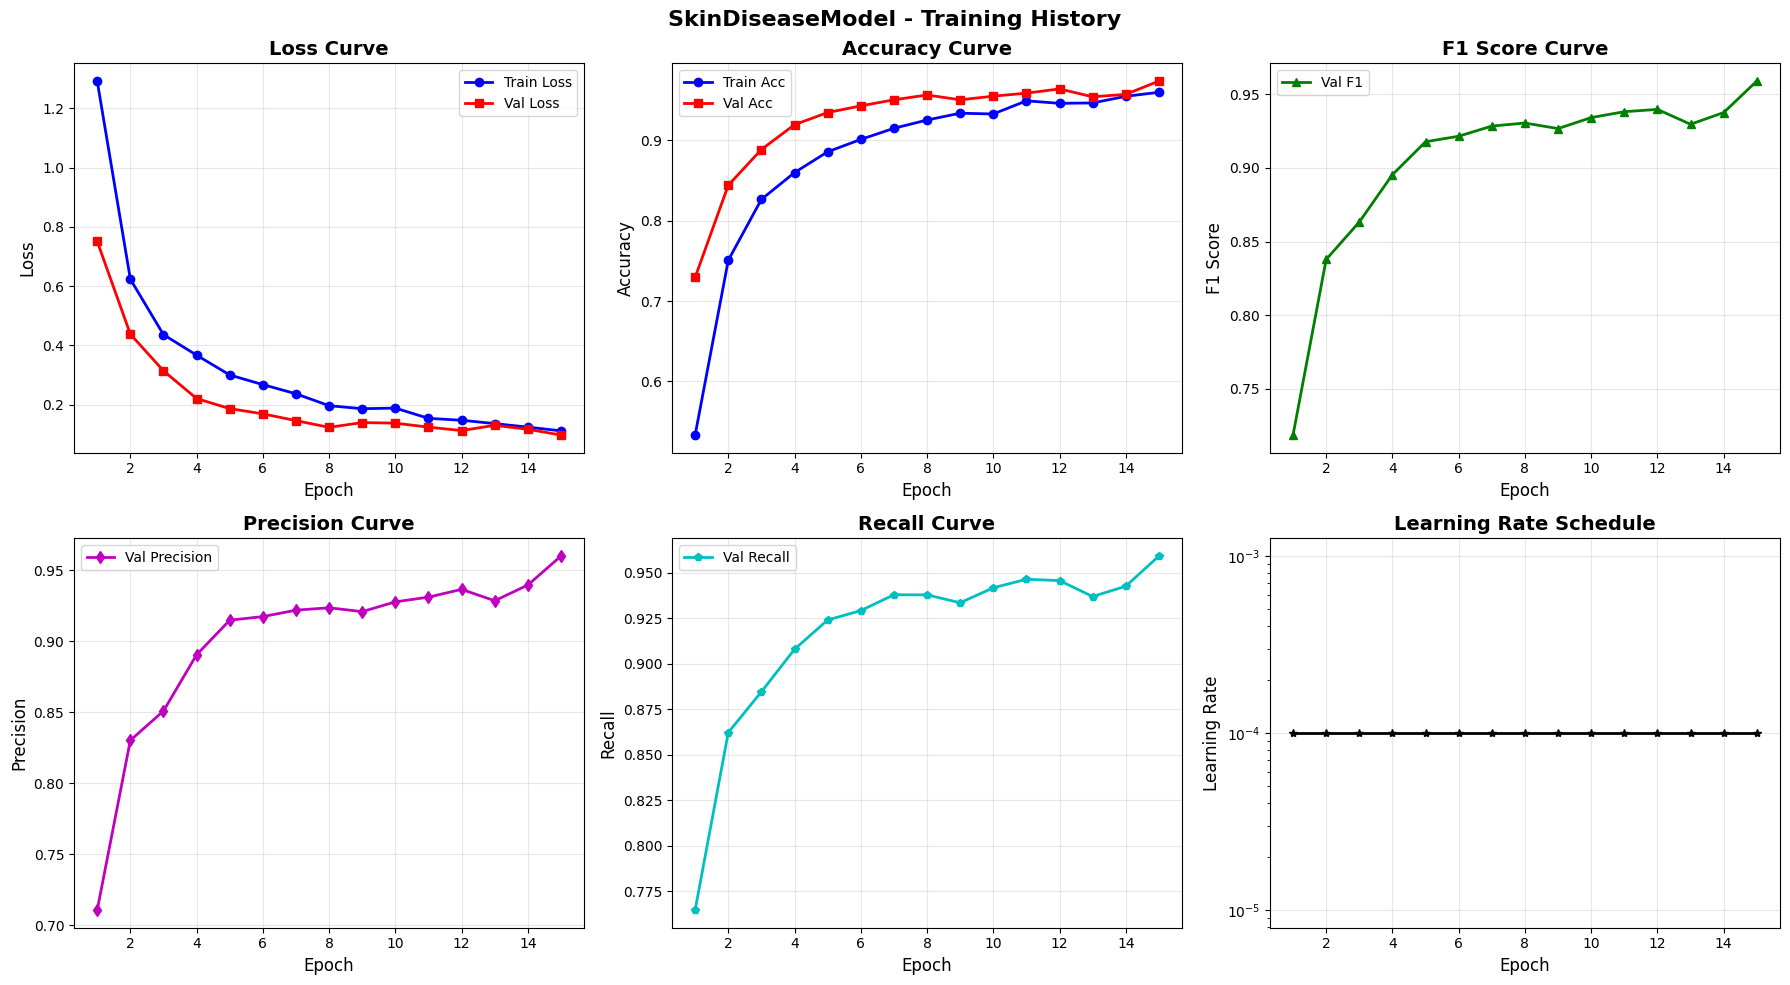

In [16]:
# ==================== PLOT TRAINING HISTORY ====================
plot_training_history(history, model_name="SkinDiseaseModel")



Evaluating on Validation Set


Evaluating Validation: 100%|██████████| 42/42 [00:06<00:00,  6.54it/s]



Validation Set Results:
Accuracy:          0.9736 (97.36%)
F1 Score (Macro):  0.9589
F1 Score (Weighted): 0.9737
Precision (Macro): 0.9598
Recall (Macro):    0.9593


Detailed Classification Report (Validation Set):
                         precision    recall  f1-score   support

      Actinic keratoses     0.9250    0.8605    0.8916        86
             Chickenpox     0.9561    0.9732    0.9646       112
                 Cowpox     0.9706    1.0000    0.9851        99
         Dermatofibroma     0.9524    0.8696    0.9091        23
                   HFMD     0.9958    0.9876    0.9917       241
                Healthy     0.9771    1.0000    0.9884       171
                Measles     1.0000    0.9878    0.9939        82
              Monkeypox     0.9929    0.9789    0.9858       426
Squamous cell carcinoma     0.8286    0.9355    0.8788        62
       Vascular lesions     1.0000    1.0000    1.0000        25

               accuracy                         0.9736      1327
 

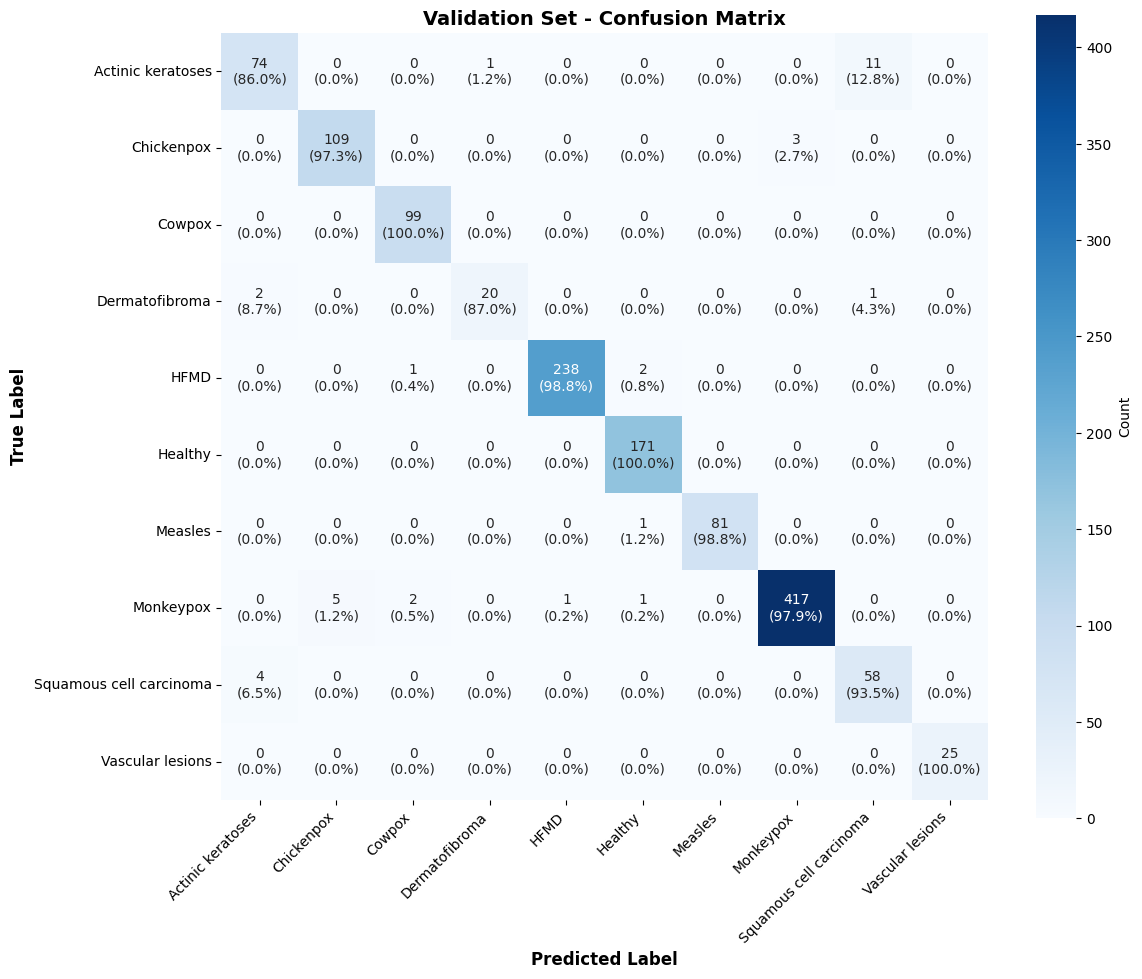

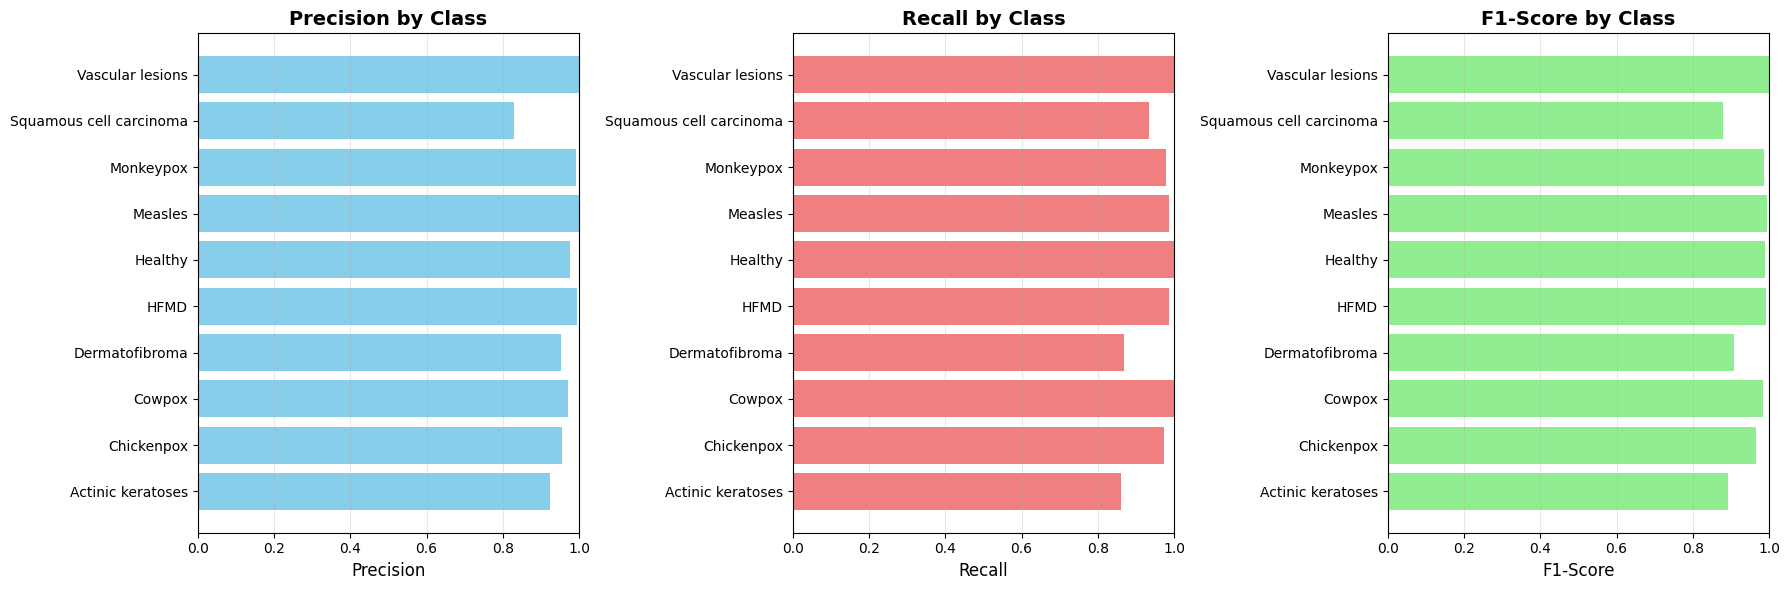


Per-Class Performance (Validation Set):
                  Class  Precision   Recall  F1-Score  Support
      Actinic keratoses   0.925000 0.860465  0.891566       86
             Chickenpox   0.956140 0.973214  0.964602      112
                 Cowpox   0.970588 1.000000  0.985075       99
         Dermatofibroma   0.952381 0.869565  0.909091       23
                   HFMD   0.995816 0.987552  0.991667      241
                Healthy   0.977143 1.000000  0.988439      171
                Measles   1.000000 0.987805  0.993865       82
              Monkeypox   0.992857 0.978873  0.985816      426
Squamous cell carcinoma   0.828571 0.935484  0.878788       62
       Vascular lesions   1.000000 1.000000  1.000000       25


In [17]:
# ==================== EVALUATE ON VALIDATION SET ====================
val_results = evaluate_model(model, val_loader, dataset_name="Validation")


Evaluating on Test Set


Evaluating Test: 100%|██████████| 42/42 [00:10<00:00,  3.90it/s]



Test Set Results:
Accuracy:          0.9663 (96.63%)
F1 Score (Macro):  0.9466
F1 Score (Weighted): 0.9666
Precision (Macro): 0.9443
Recall (Macro):    0.9498


Detailed Classification Report (Test Set):
                         precision    recall  f1-score   support

      Actinic keratoses     0.9268    0.8636    0.8941        88
             Chickenpox     0.9492    0.9912    0.9697       113
                 Cowpox     0.9327    0.9798    0.9557        99
         Dermatofibroma     0.8800    0.8800    0.8800        25
                   HFMD     0.9959    0.9917    0.9938       242
                Healthy     0.9709    0.9766    0.9738       171
                Measles     0.9759    0.9759    0.9759        83
              Monkeypox     0.9952    0.9718    0.9834       426
Squamous cell carcinoma     0.8169    0.9062    0.8593        64
       Vascular lesions     1.0000    0.9615    0.9804        26

               accuracy                         0.9663      1337
             

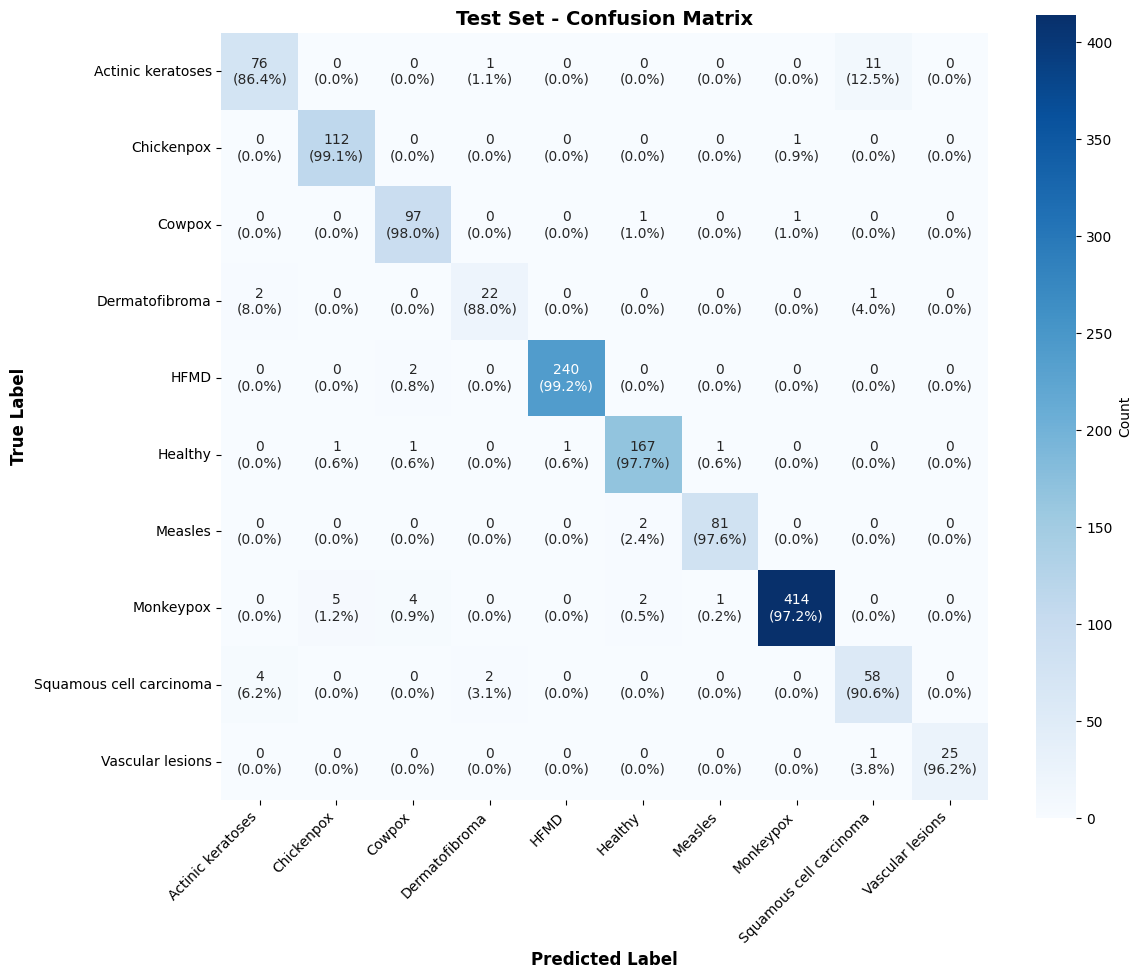

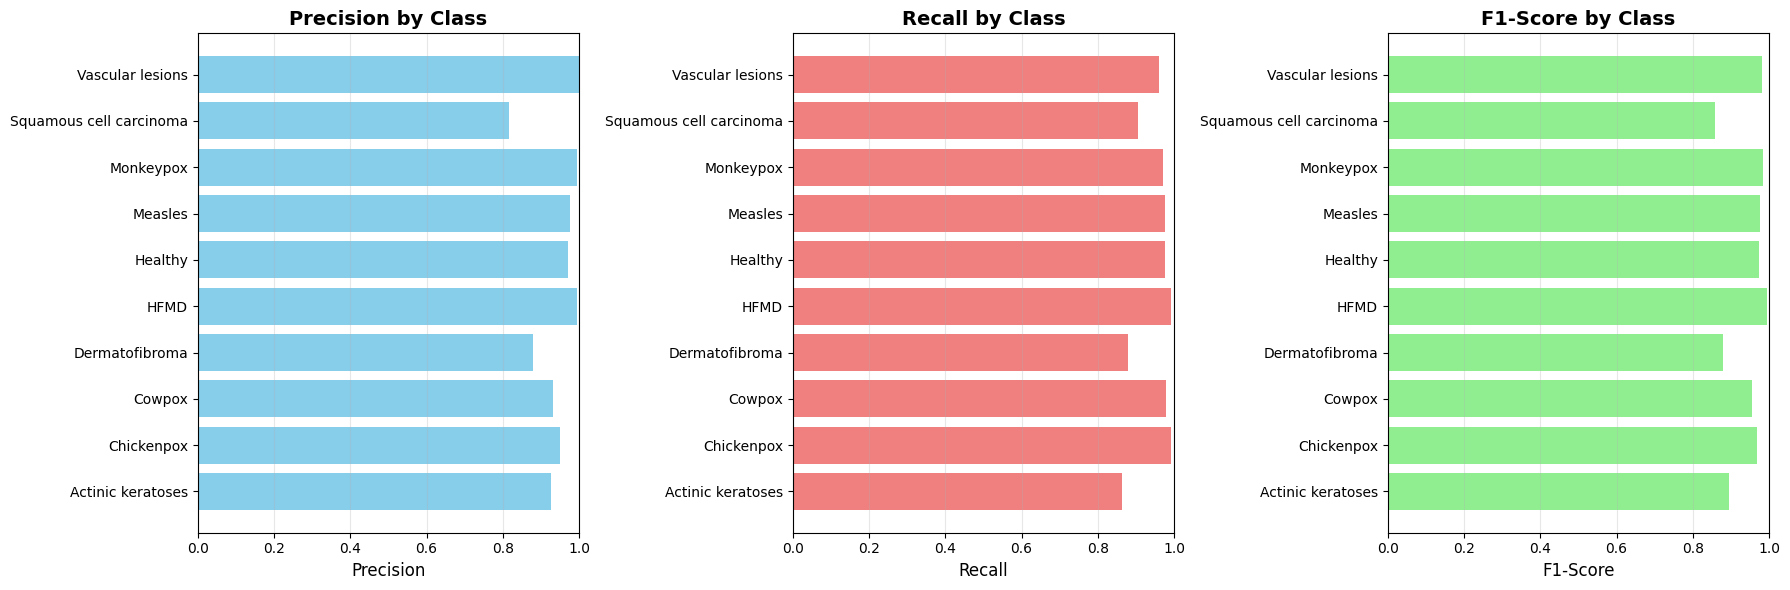


Per-Class Performance (Test Set):
                  Class  Precision   Recall  F1-Score  Support
      Actinic keratoses   0.926829 0.863636  0.894118       88
             Chickenpox   0.949153 0.991150  0.969697      113
                 Cowpox   0.932692 0.979798  0.955665       99
         Dermatofibroma   0.880000 0.880000  0.880000       25
                   HFMD   0.995851 0.991736  0.993789      242
                Healthy   0.970930 0.976608  0.973761      171
                Measles   0.975904 0.975904  0.975904       83
              Monkeypox   0.995192 0.971831  0.983373      426
Squamous cell carcinoma   0.816901 0.906250  0.859259       64
       Vascular lesions   1.000000 0.961538  0.980392       26


In [18]:
# ==================== EVALUATE ON TEST SET ====================
test_results = evaluate_model(model, test_loader, dataset_name="Test")

In [19]:
# ==================== SAVE FINAL RESULTS ====================
print("\n" + "="*70)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*70)
print(f"\nValidation Set:")
print(f"  Accuracy:  {val_results['accuracy']:.4f}")
print(f"  F1 Score:  {val_results['f1_macro']:.4f}")
print(f"\nTest Set:")
print(f"  Accuracy:  {test_results['accuracy']:.4f}")
print(f"  F1 Score:  {test_results['f1_macro']:.4f}")
print("="*70)

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'class_names': class_names,
    'num_classes': num_classes,
    'val_results': val_results,
    'test_results': test_results
}, 'final_skin_disease_model.pth')

print("\n✓ Model and results saved successfully!")
print("  - Model checkpoint: final_skin_disease_model.pth")
print("  - Training history plots saved")
print("  - Confusion matrices saved")
print("  - Performance charts saved")


FINAL MODEL PERFORMANCE SUMMARY

Validation Set:
  Accuracy:  0.9736
  F1 Score:  0.9589

Test Set:
  Accuracy:  0.9663
  F1 Score:  0.9466

✓ Model and results saved successfully!
  - Model checkpoint: final_skin_disease_model.pth
  - Training history plots saved
  - Confusion matrices saved
  - Performance charts saved


In [20]:
val_loss = 0.0
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)


In [21]:
val_loss = val_loss / len(val_loader.dataset)

In [23]:
val_results = {
    'loss': val_loss
}

In [24]:
print(f"  Loss:      {val_results['loss']:.4f}")


  Loss:      0.0975
